## apples with apples

we're worried we might miss improvements in our model because of poor initialization and random instablilities as we train.

lets take a look at what's happening in our layers and try to fix things

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
context_length = 5
embedding_dimensions = 3

In [3]:
%run ../lib/basic_sampling.py

In [4]:
names = NameSampling("../resources/names.txt")

x, y = names.get_xys(names.sample_names(2))

vocab_size = len(names.itos)
names_length = names.names_length

## Let's look at initialization

we'll initialize our system weights a few times and plot them

In [5]:
import matplotlib.pyplot as plt

tensor(1.0128)
tensor(0.9759)
tensor(1.0228)
tensor(1.0303)


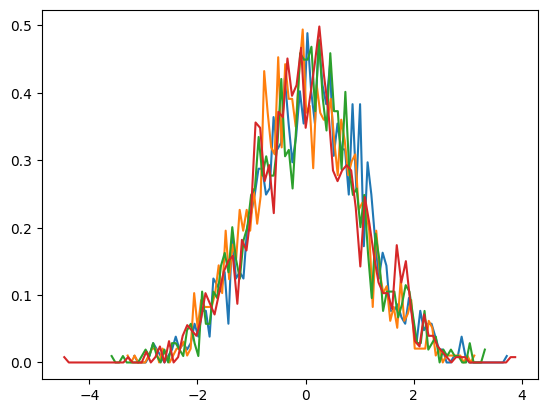

In [6]:
for i in range(4):
    ws = torch.randn(embedding_dimensions*context_length, 100)
    print(ws.var())
    hy, hx = torch.histogram(ws, density=True)
    plt.plot(hx.detach()[1:], hy.detach())

variance in our weights can lead to very large or very small activations and those lead our gradients to explode or vanish

we want to squash our weight

### But...

before we tackle that:

lets take a look at our activations and gradients so we can compare them with later models

(we used relu last time - but we'll use tanh to give a 'prettier' visualization)

In [7]:
# keep the same values for the experiments
epochs = 120
batch_size = 800
learning_rate = .2
samples = 1000

In [8]:
es = torch.randn((vocab_size, embedding_dimensions), requires_grad=True)

W1 = torch.randn((embedding_dimensions*context_length, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [es, W1, b1, W2, b2]

### keep track of weights, activations and gradients

In [9]:
track = {'weights': [], 'activations': [], 'gradients': [], 'loss': [], 'learning_rate': []}

In [10]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = names.get_xys(names.sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        
        outputL1 = torch.tanh(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2
        
        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    learning_rate *= .99

    if ep % 10 == 0:

        track['weights'].append(W1.detach())
        track['activations'].append(outputL1.detach())
        track['gradients'].append(W1.grad.detach())
        
        print(ep, learning_rate)
        print(epoch_loss/samples)

0 0.198
tensor(2.9730, grad_fn=<DivBackward0>)
10 0.17906765085174328
tensor(2.3173, grad_fn=<DivBackward0>)
20 0.16194557364425166
tensor(2.2740, grad_fn=<DivBackward0>)
30 0.14646067393087944
tensor(2.2533, grad_fn=<DivBackward0>)
40 0.13245640819679666
tensor(2.2406, grad_fn=<DivBackward0>)
50 0.1197912012932322
tensor(2.2293, grad_fn=<DivBackward0>)
60 0.10833701519337073
tensor(2.2229, grad_fn=<DivBackward0>)
70 0.097978054600841
tensor(2.2157, grad_fn=<DivBackward0>)
80 0.08860959632523453
tensor(2.2103, grad_fn=<DivBackward0>)
90 0.08013693059030814
tensor(2.2060, grad_fn=<DivBackward0>)
100 0.07247440357209944
tensor(2.2016, grad_fn=<DivBackward0>)
110 0.06554455148756082
tensor(2.1985, grad_fn=<DivBackward0>)


### The non linearity

we've chosen tanh to highlight problems with activations and gradients but without proper initialization all non-linearities are prone to instability.

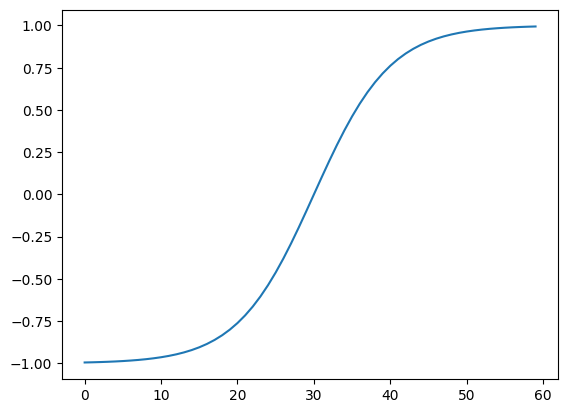

In [11]:
r = torch.tanh(torch.arange(-3, 3, .1))
plt.plot(r)

### What happens when we train?

our histogram of activations shows the tanh creating a lot of -1 or 1 values

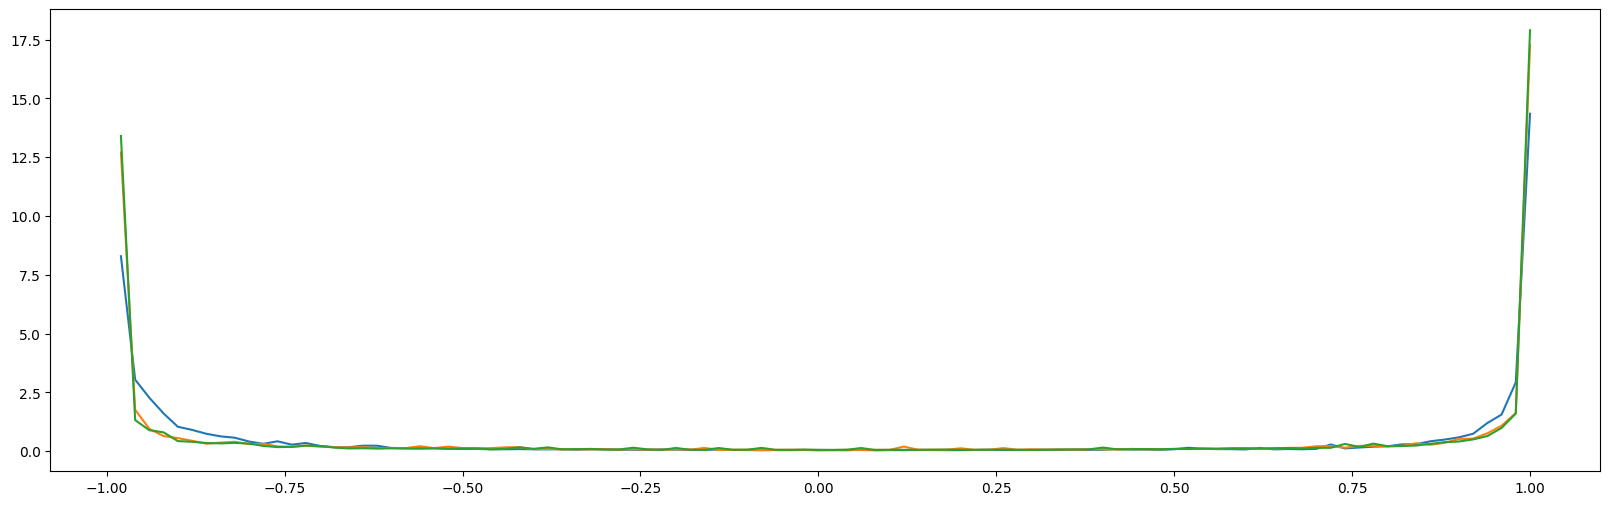

In [12]:
plt.figure(figsize=(20,6))

# for i in range(10):
#     hy, hx = torch.histogram(track['gradients'][i], density=True)
#     plt.plot(hx.detach()[1:], hy.detach())

hy, hx = torch.histogram(track['activations'][0], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][5], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][9], density=True)
plt.plot(hx.detach()[1:], hy.detach())

### Our gradients

we're always getting a lot of zero gradients

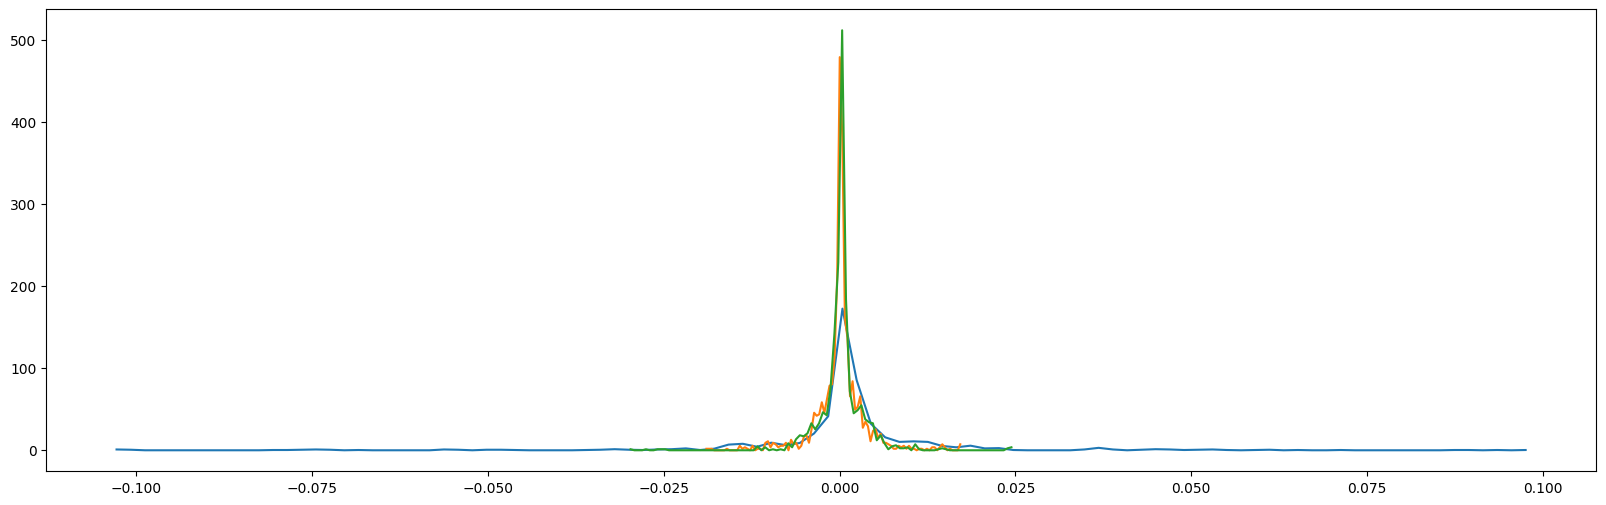

In [13]:
plt.figure(figsize=(20,6))

# for i in range(10):
#     hy, hx = torch.histogram(track['gradients'][i], density=True)
#     plt.plot(hx.detach()[1:], hy.detach())

hy, hx = torch.histogram(track['gradients'][0], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][5], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][9], density=True)
plt.plot(hx.detach()[1:], hy.detach())

## Now run the same network

so to begin we'll just reduce the variance of our weights using a Kaiming normal distribution

otherwise we run exactly the same network as last time

In [14]:
vocab_size = len(names.itos)

es = torch.randn((vocab_size, embedding_dimensions), requires_grad=True)

W1 = torch.randn((embedding_dimensions*context_length, 100), requires_grad=True)

nn.init.kaiming_normal_(W1, nonlinearity='tanh')

b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)

b2 = torch.randn(27, requires_grad=True)

parameters = [es, W1, b1, W2, b2]

## Different

maybe unsurprisingly the weights look pretty different now

we've squashed them in so there's a much smaller variance 

(this is a histogram so the y axis is counts not value)

tensor(0.0277, grad_fn=<VarBackward0>)


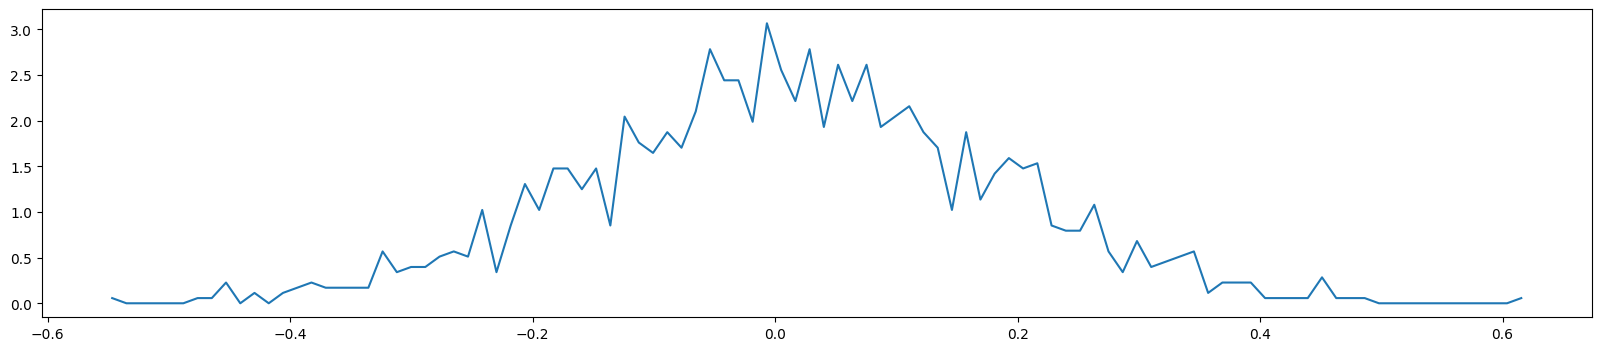

In [15]:
plt.figure(figsize=(20,4))

hy, hx = torch.histogram(W1, density=True)
plt.plot(hx.detach()[1:], hy.detach())

print(W1.var())

In [16]:
track = {'weights': [], 'activations': [], 'gradients': [], 'loss': [], 'learning_rate': []}

In [17]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = names.get_xys(names.sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        
        outputL1 = torch.tanh(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2
        
        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    learning_rate *= .99

    if ep % 10 == 0:
        track['weights'].append(W1.detach())
        track['activations'].append(outputL1.detach())
        track['gradients'].append(W1.grad.detach())
        
        print(ep, learning_rate)
        print(epoch_loss/samples)

0 0.05927731747984169
tensor(2.6535, grad_fn=<DivBackward0>)
10 0.053609343383374905
tensor(2.2613, grad_fn=<DivBackward0>)
20 0.04848332920891612
tensor(2.2264, grad_fn=<DivBackward0>)
30 0.043847453873294535
tensor(2.2114, grad_fn=<DivBackward0>)
40 0.03965485131778294
tensor(2.2023, grad_fn=<DivBackward0>)
50 0.03586313671894215
tensor(2.1955, grad_fn=<DivBackward0>)
60 0.032433978002201345
tensor(2.1894, grad_fn=<DivBackward0>)
70 0.02933270832642077
tensor(2.1864, grad_fn=<DivBackward0>)
80 0.026527975621876455
tensor(2.1828, grad_fn=<DivBackward0>)
90 0.023991425638695604
tensor(2.1802, grad_fn=<DivBackward0>)
100 0.02169741530154296
tensor(2.1785, grad_fn=<DivBackward0>)
110 0.019622753472737207
tensor(2.1758, grad_fn=<DivBackward0>)


## Better activations

we now have smaller tails at -1 an 1 for our tanh activations

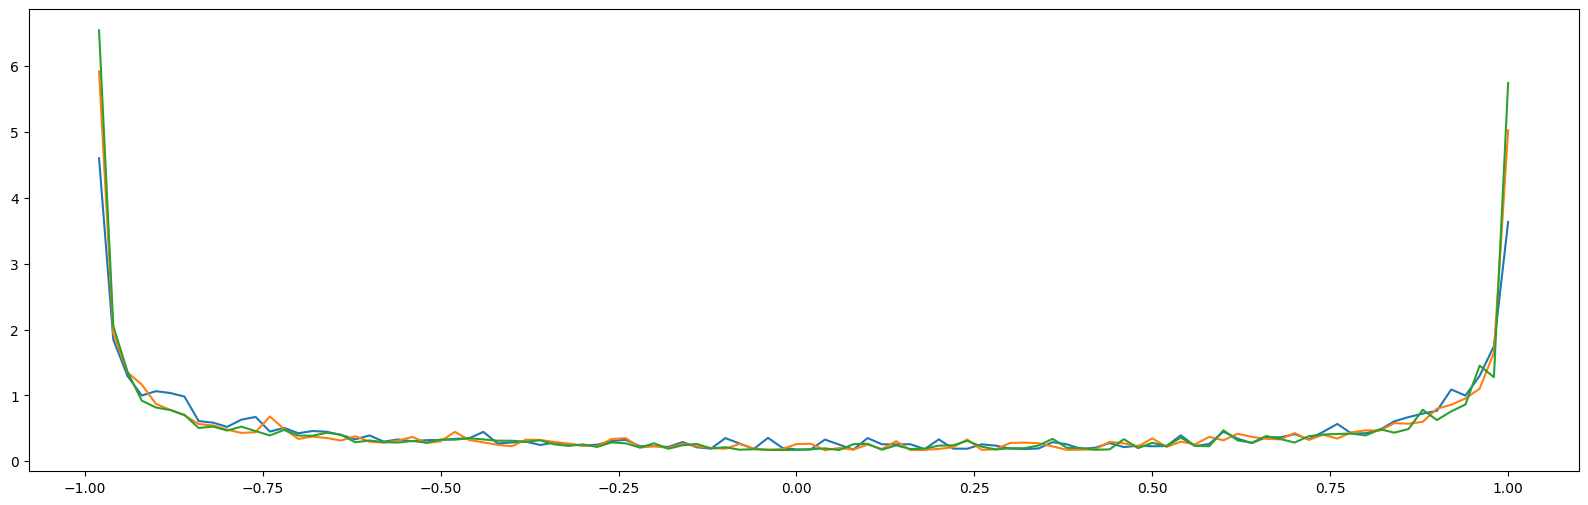

In [19]:
plt.figure(figsize=(20,6))

# for i in range(10):
#     hy, hx = torch.histogram(track['gradients'][i], density=True)
#     plt.plot(hx.detach()[1:], hy.detach())

hy, hx = torch.histogram(track['activations'][2], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][6], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['activations'][10], density=True)
plt.plot(hx.detach()[1:], hy.detach())

## This results in better gradient flow 
with significantly lower zero gradient counts

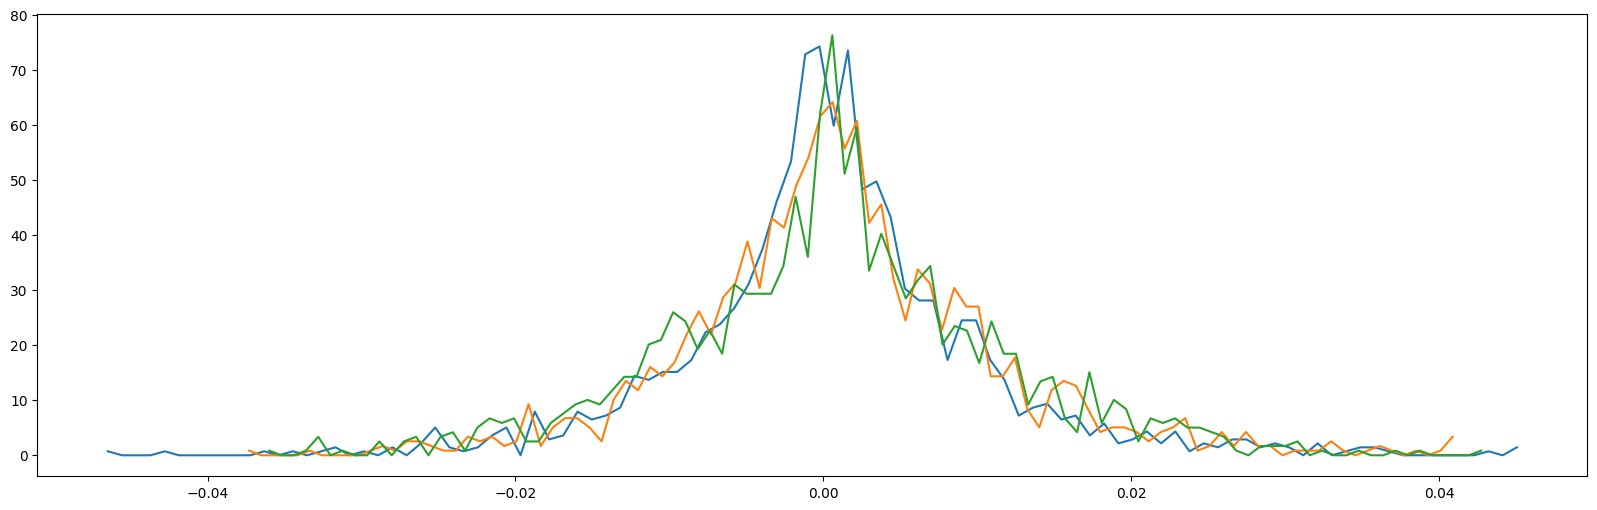

In [20]:
plt.figure(figsize=(20,6))

hy, hx = torch.histogram(track['gradients'][2], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][5], density=True)
plt.plot(hx.detach()[1:], hy.detach())
hy, hx = torch.histogram(track['gradients'][9], density=True)
plt.plot(hx.detach()[1:], hy.detach())

In [21]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = [0, 0, 0, 0, 0]
        for nl in range(10):
            xenc = es[ix]

            outputL1 = torch.tanh(xenc.view(-1, embedding_dimensions * context_length) @ W1 + b1)
            
            logits = outputL1 @ W2 + b2
            
            p = F.softmax(logits, dim=1)
    
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(names.itos[prediction])
            
        print("".join(out))

In [22]:
generate_names(10)

boibley
merry
monala
anles
bina
arrekranle
melac
taylee
cenila
hin


### Still in 3D

so we can easily plot our characters after training

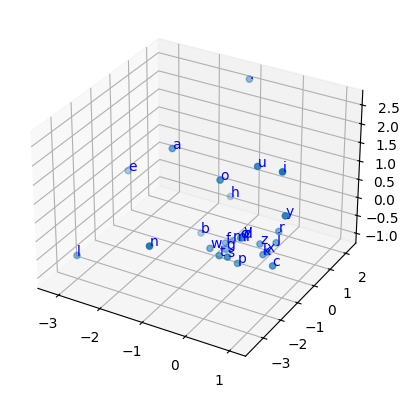

In [23]:
x = es.T[0].tolist()
y = es.T[1].tolist()
z = es.T[2].tolist()
n = ['.'] + names.letters

fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.view_init(elev, azim)
# ax.set_box_aspect((1, 1, 1), zoom=zoom)

ax.scatter(x, y, z)

for i, txt in enumerate(n):
    # ax.annotate(txt, (x[i], y[i], z[i]))
    ax.text(x[i], y[i], z[i], txt, color='blue')

## Next time

fill out a few more initializations and go to more dimensions.